In [1]:
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

### Data Set 

Data Set used for the experiment: Tic-Tac-Toe Endgame (Available at https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame)

In [2]:
df = pd.read_csv('tictactoedataset.csv')
df.head()

,tl,tm,tr,ml,mm,mr,bl,bm,br,class
0,x,x,x,x,o,o,o,x,o,positive
1,x,x,x,x,o,o,o,o,x,positive
2,x,x,x,x,o,o,o,b,b,positive
3,x,x,x,x,o,o,b,o,b,positive
4,x,x,x,x,o,o,b,b,o,positive


The dataset is filled with labels for each position, indicating whether the position is filled by "x", "o" or if it's blank ("b")
We will try to predict the class, which may be "positive", indicating "x" has won, or negative.
</br></br>

The Gradient Boosting Algorithm we are going to implement is not capable of understanding letters, so we will run the data set through a one hot encoding proccess. Each X column will be split in 3, one that will be filled if the positon was filled with "x", one for "o" and one for "b".

So if tl (top left) = "o", the encoded dataset will have tl_x = 0, tl_o = 1, tl_b = 0


In [3]:


def one_hot(df):
    # One hot encode the categorical values
    new_columns = []
    for c in df.columns:
        if c == 'class': 
            new_columns.append(c)
            continue
        new_columns.append(f'{c}_x')
        new_columns.append(f'{c}_b')
        new_columns.append(f'{c}_o')

    new_data = {}
    for c in new_columns:
        new_data[c] = []

    new_df = pd.DataFrame(new_data)
    columns_count = len(new_columns)

    for v in df.values:
        new_row = [0] * columns_count
        for i in range(len(v)):
            val = v[i]
            if i == len(v) - 1:
                new_row[columns_count-1] = 1 if val == 'positive' else 0
                continue

            pos = -1
            if val == 'x':
                pos = 3*i + 0
            elif val == 'b':
                pos = 3*i + 1
            elif val == 'o':
                pos = 3*i + 2
            new_row[pos] = 1

        series = pd.Series(new_row, index = new_df.columns)
        new_df = new_df.append(series, ignore_index=True)
    return new_df


df = one_hot(df)
df.head()

,tl_x,tl_b,tl_o,tm_x,tm_b,tm_o,tr_x,tr_b,tr_o,ml_x,...,bl_x,bl_b,bl_o,bm_x,bm_b,bm_o,br_x,br_b,br_o,class
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


## MyGradientBoostingClassifier
This is an implementation of the Gradient Boosting Classifier Algorithm

In [4]:
class MyGradientBoostingClassifier:

    def __init__(self, learning_rate=0.2, max_depth=10, n_estimators=100, min_samples_leaf=5):
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.min_samples_leaf = min_samples_leaf

    def p_to_log_odds(self, p):
        return math.log2(p/(1-p))

    def log_odds_to_p(self, log_odds):
        return math.pow(math.e, log_odds) / (1 + math.pow(math.e, log_odds))
            
            
    def fit(self, df_x, df_y):
        self.estimators = []
        df_gb = df_x
        
        
        # Step 1: Initialize the model with a constant value (current probability that a sample is true)
        initial_prob = len(df_y[df_y == 1])/len(df_y)
        predict_proba = [initial_prob] * len(df_gb)
        log_odds = [self.p_to_log_odds(initial_prob)] * len(df_gb)
        residual = []
        
        self.initial_log_odds = log_odds[0]


        # Step 2: Repeat n_estimators times
        for _ in range(self.n_estimators):
            # Step 2.1: Compute the Pseudo Residuals for each sample, r(i,m), where i is the sample number and m is the tree that we’re building.
            # Pseudo residual = Observed - p
            residual = (df_y - predict_proba).values
            tree = DecisionTreeRegressor(
                splitter="best",
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                min_samples_split=2,
                min_weight_fraction_leaf= 0.0,
                min_impurity_decrease=0.0,
            )
            
            tree.fit(df_gb, residual)
            self.estimators.append(tree)

            gamma = tree.predict(df_gb)
            log_odds += gamma * self.learning_rate

            for i in range(len(df_gb)):                
                predict_proba[i] = self.log_odds_to_p(log_odds[i])

        hit = 0
        for i in range(0, len(df_gb)):
            if predict_proba[i] >= 0.5 and df_y.iloc[i] == 1:
                hit += 1
            elif predict_proba[i] < 0.5 and df_y.iloc[i] == 0:
                hit += 1

    def predict_proba(self, X, per_iter=False):

        if per_iter:
            yy = []
            y = []

            odds =  [self.initial_log_odds] * len(X)
            for tree in self.estimators:
                gamma = tree.predict(X)
                odds += self.learning_rate * gamma
            
                for i in range(len(X)):
                    y.append(self.log_odds_to_p(odds[i]))
                yy.append(y)
                y = []

            return yy
            
        else:
            y = []

            odds =  [self.initial_log_odds] * len(X)
            for tree in self.estimators:
                gamma = tree.predict(X)
                odds += self.learning_rate * gamma
            
            for i in range(len(X)):
                y.append(self.log_odds_to_p(odds[i]))

            return y

    def score_per_iter(self, X, y):
        proba = self.predict_proba(X, per_iter=True)
        scores = []
        for i in range(len(proba)):
            scores.append(self.score(X, y, predicted_proba=proba[i]))
        return scores

    def score(self, X, y, predicted_proba=None):
        predicted_proba = self.predict_proba(X) if predicted_proba == None else predicted_proba

        hit = 0
        for i in range(len(predicted_proba)):
            res = 1 if predicted_proba[i] >= 0.5 else 0
            if y.iloc[i] == res:
                hit += 1
        return hit/len(predicted_proba)


### Simple test with train test split of 85/15

Accuracy ranges from about 96% to 100%

In [5]:
X = df.loc[:, df.columns != 'class']
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

clf = MyGradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_depth=15, min_samples_leaf=10)
clf.fit(df_x=X_train, df_y=y_train)
    
print(f'Test accuracy {clf.score(X_test, y_test)}')

Test accuracy 0.9791666666666666


### Cross Validation (5 folds)



In [6]:
def cross_val_score(estimator=clf, X=X, y=y, cv=5):
    X, y = shuffle(X, y)

    total_size = len(X)
    fold_size = int(total_size / cv)
    scores = []
    for i in range(cv):
        start = i * fold_size
        end = (i + 1) * fold_size
        xTest = X[start:end]
        yTest= y[start:end]
        xTrain = pd.concat([X[:start], X[end:]])
        yTrain = pd.concat([y[:start], y[end:]])

        estimator.fit(xTrain, yTrain)
        scores.append(estimator.score(xTest, yTest))
    return np.array(scores)
    
clf = MyGradientBoostingClassifier(n_estimators=400, learning_rate=0.6, max_depth=15, min_samples_leaf=10)
scores = cross_val_score(estimator=clf, X=X, y=y, cv=5)
print(f'Scores: {scores}')
print(f'Average Score: {scores.mean()}')

Scores: [0.9895288  0.97905759 0.9947644  0.98429319 0.98429319]
Average Score: 0.9863874345549737


### Iterations Experiment
Usually, a total of ~400 iterations is enough to maximize the results

The graph generated above shows the evolution of the accuracy with each iteration

Last Score 1.0


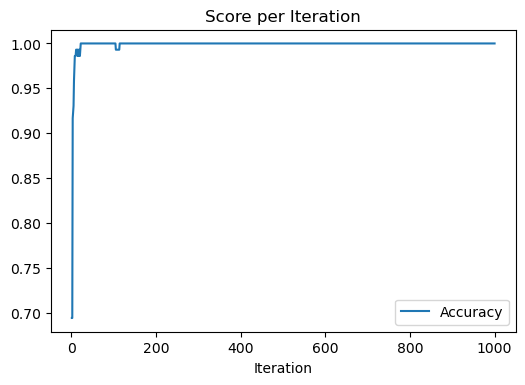

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

clf = MyGradientBoostingClassifier(n_estimators=1000, learning_rate=0.6, max_depth=15, min_samples_leaf=10)
clf.fit(df_x=X_train, df_y=y_train)
    
scores = clf.score_per_iter(X_test, y_test)
print(f'Last Score {scores[-1]}')

plt.figure(dpi=100)
cols = np.array(list(range(len(scores)))) + 1
plt.plot(cols, scores)
plt.title('Score per Iteration')
plt.ylabel('')
plt.xlabel('Iteration')
plt.legend(['Accuracy'], loc='lower right')
plt.show()


### Max Depth Experiment

Small max depth numbers (approximately < 4), are empirically considerably worse than bigger numbers. Usually, big numbers could cause overfitting, but the boosting process prevent that.
The experiments were run with a min_samples_leaf of 10. This causes the max depth to not cause significant difference for max depth ~= 9+, since the branches of the tree can't split past a number of 10 elements per leaf.
</br></br>You can notice this behavior on the graph below. Optimal max_depth seems to be > 10. We will use 15.

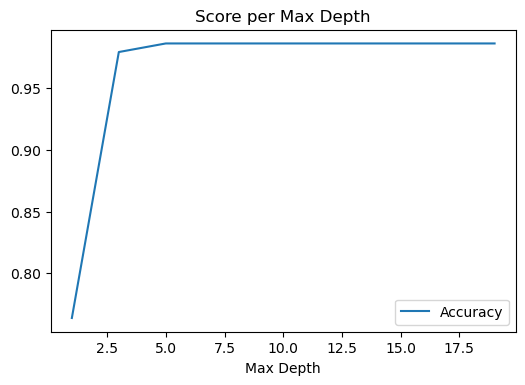

[0.7638888888888888, 0.9791666666666666, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

depths = np.array(list(range(10)))*2 + 1
scores = []
for depth in depths:
    clf = MyGradientBoostingClassifier(n_estimators=400, learning_rate=0.6, max_depth=depth, min_samples_leaf=10)
    clf.fit(df_x=X_train, df_y=y_train)
    scores.append(clf.score(X_test, y_test))

plt.figure(dpi=100)
plt.plot(depths, scores)
plt.title('Score per Max Depth')
plt.ylabel('')
plt.xlabel('Max Depth')
plt.legend(['Accuracy'], loc='lower right')
plt.show()

print(scores)



### Minimum Samples per Leaf Experiment

As you can by generating the graph below a few times, no consistent results were found for a specific optimal value for min_samples_leaf. A reasonable range seems to be [7-15], we will use 10.

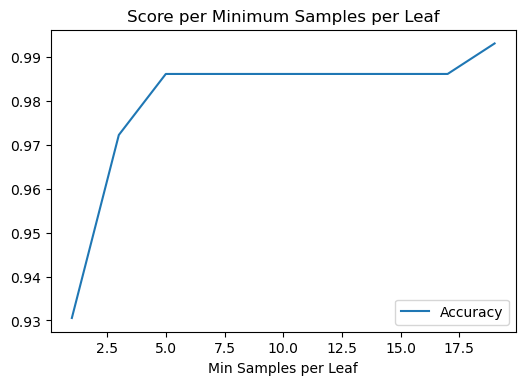

[0.9305555555555556, 0.9722222222222222, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9930555555555556]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

samples = np.array(list(range(10)))*2 + 1
scores = []
for sample_number in samples:
    clf = MyGradientBoostingClassifier(n_estimators=400, learning_rate=0.6, max_depth=15, min_samples_leaf=sample_number)
    clf.fit(df_x=X_train, df_y=y_train)
    scores.append(clf.score(X_test, y_test))

plt.figure(dpi=100)
plt.plot(samples, scores)
plt.title('Score per Minimum Samples per Leaf')
plt.ylabel('')
plt.xlabel('Min Samples per Leaf')
plt.legend(['Accuracy'], loc='lower right')
plt.show()

print(scores)



### Learning Rate Experiment

Different values of learning rate don't seem to significantly affect the accuracy. By running this experiment a few times, values between 0.3 and 1.0 seem to be close to equivalent.

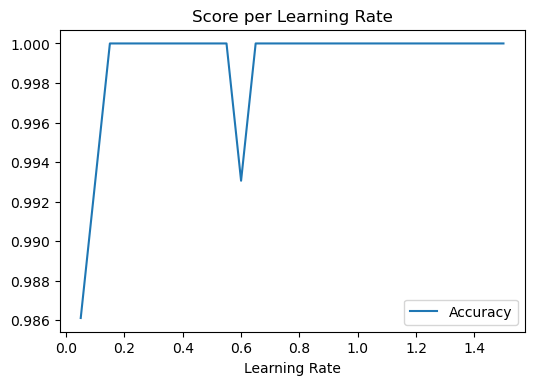

[0.9861111111111112, 0.9930555555555556, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9930555555555556, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

rates = (np.array(list(range(30))) + 1) / 20
scores = []
for rate in rates:
    clf = MyGradientBoostingClassifier(n_estimators=400, learning_rate=rate, max_depth=15, min_samples_leaf=10)
    clf.fit(df_x=X_train, df_y=y_train)
    scores.append(clf.score(X_test, y_test))

plt.figure(dpi=100)
plt.plot(rates, scores)
plt.title('Score per Learning Rate')
plt.ylabel('')
plt.xlabel('Learning Rate')
plt.legend(['Accuracy'], loc='lower right')
plt.show()

print(scores)

